In [1]:
import sys
sys.version

'3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) \n[Clang 6.0 (clang-600.0.57)]'

In [45]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
from time import time

In [3]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')


with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [4]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


### Data to get ...

For each user:
- articles read
- embeddings for those articles

Relevant columns from clicks:
- uer_id
- click_article_id

In [60]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id']
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [61]:
user_clicks = get_click_data()

In [62]:
user_clicks.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


In [63]:
user_clicks.nunique()

user_id             322897
click_article_id     46033
dtype: int64

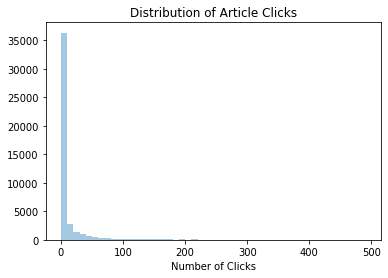

Min: 1
Max: 34145


In [64]:
sns.distplot(
    user_clicks.click_article_id.value_counts(),
    kde=False,
    bins=np.arange(0,500,10)
).set_title('Distribution of Article Clicks')
plt.xlabel('Number of Clicks')
plt.show()

print('Min:', user_clicks.click_article_id.value_counts().min())
print('Max:', user_clicks.click_article_id.value_counts().max())

Article clicks are skewed heavily left.

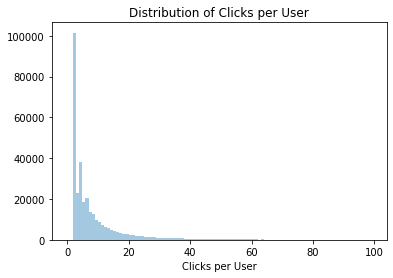

Min: 2
Max: 1048


In [65]:
sns.distplot(
    user_clicks.user_id.value_counts(),
    kde=False,
    bins = np.arange(0,100,1)
).set_title('Distribution of Clicks per User')
plt.xlabel('Clicks per User')
plt.show()

print('Min:', user_clicks.user_id.value_counts().min())
print('Max:', user_clicks.user_id.value_counts().max())

## Merged Dataframe of User/Article/Embedding

In [23]:
df = user_clicks.merge(
    pd.DataFrame(embeddings),
    how='left',
    left_on='click_article_id',
    right_index=True
)

In [24]:
df.head()

,user_id,click_article_id,0,1,2,3,4,5,6,7,...,240,241,242,243,244,245,246,247,248,249
0,0,157541,0.045636,-0.981722,-0.348812,0.135374,0.187598,0.461542,-0.792449,0.510303,...,0.670260,0.299059,-0.826797,-0.812070,0.382404,-0.081983,-0.802341,-0.418486,0.167978,0.278694
1,0,68866,-0.090528,-0.970437,-0.169124,-0.241913,-0.139705,-0.317429,-0.614713,0.837383,...,0.421613,-0.228761,-0.791743,0.021998,-0.019606,0.146993,-0.811947,-0.396069,0.301935,0.486068
2,1,235840,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,-0.340086,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,96663,-0.463952,-0.958577,-0.317925,0.143565,0.009962,0.510263,-0.703141,-0.227401,...,0.779381,0.505448,-0.262309,-0.442881,0.695514,0.748444,-0.209889,-0.231323,-0.082891,-0.203830
4,2,119592,-0.954936,-0.972117,0.428549,-0.796103,0.579418,-0.176027,-0.564019,-0.596843,...,-0.501580,-0.096082,0.303779,-0.502767,0.390972,0.489991,0.255620,0.087651,0.189143,-0.459281


In [25]:
df.to_csv('data/user_embeddings.csv')

#### read back

In [66]:
start = time()
df = pd.read_csv('data/user_embeddings.csv',index_col=0)
print(time()-start)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


149.3751151561737


In [67]:
df.head()

,user_id,click_article_id,0,1,2,3,4,5,6,7,...,240,241,242,243,244,245,246,247,248,249
0,0,157541,0.045636,-0.981722,-0.348812,0.135374,0.187598,0.461542,-0.792449,0.510303,...,0.670260,0.299059,-0.826797,-0.812070,0.382404,-0.081983,-0.802341,-0.418486,0.167978,0.278694
1,0,68866,-0.090528,-0.970437,-0.169124,-0.241913,-0.139705,-0.317429,-0.614713,0.837383,...,0.421613,-0.228761,-0.791743,0.021998,-0.019606,0.146993,-0.811947,-0.396069,0.301935,0.486068
2,1,235840,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,-0.340086,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,96663,-0.463952,-0.958577,-0.317925,0.143565,0.009962,0.510263,-0.703141,-0.227401,...,0.779381,0.505448,-0.262309,-0.442881,0.695514,0.748444,-0.209889,-0.231323,-0.082891,-0.203830
4,2,119592,-0.954936,-0.972117,0.428549,-0.796103,0.579418,-0.176027,-0.564019,-0.596843,...,-0.501580,-0.096082,0.303779,-0.502767,0.390972,0.489991,0.255620,0.087651,0.189143,-0.459281


## To do
- sample and train/test split
- baseline model
- nonlinear model